# Central Limit Theorem in action

Here's a little notebook that visualises some common distributions, and provides a graphical example of the central limit theorem in action, i.e. how with more samples we approximate a Gaussian distribution.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Set a seed
np.random.seed(42)

In [2]:
class Distrib():
    # Define our class variables - number of samples and number of distributions from which to sample
    sample_size = 10000
    num_dists = None
    
    def __init__(self, name, params):
        self.name = name
        self.params = params
        self.samples = np.empty((Distrib.num_dists, Distrib.sample_size))
        self.means = None
    
    # Draw the samples from the number of distributions
    def drawSamples(self):
        # Check that the distribution in question actually exists in np.random
        try:
            distrib_func = getattr(np.random, self.name)
        except AttributeError:
            print("Cannot find "+self.name+" in np.random")
            raise
        
        # Draw samples and put into our array
        for i in range(Distrib.num_dists):
            self.samples[i,:] = distrib_func(**self.params, size=Distrib.sample_size)
    
    # Calculate the sample means   
    def calcMeans(self):
        self.means = np.mean(self.samples, axis=0)
        
        #print(len(np.unique(self.means)))
        
    # Plot the distributions
    def plotDistribs(self, ax):
        # Plot the histogram of the data
        # Min function on the number of bins to adjust for the discrete Poisson
        ax.hist(self.means, normed=True, bins=min(50, len(np.unique(self.means))))
    
    @staticmethod
    def generateDistribs(distrib_dict):
        # Just convert the dictionary above into objects so we can plot and manipulate them easier
        distribs = {}

        # Initialise our figure
        fig = plt.figure(figsize=(10,5))

        # Convert below into a static method?

        # Loop to draw samples, plot etc. for each distribution
        for i, (name, params) in enumerate(distrib_dict.items()):

            # Create the distribution instance
            distribs[name] = Distrib(name, params)

            # Call our methods
            distribs[name].drawSamples()
            distribs[name].calcMeans()

            # Add a subplot for the distribution
            ax = fig.add_subplot(1, len(distrib_dict), i+1)

            # Plot the distributions
            Distrib.plotDistribs(distribs[name], ax)
            
            ax.set_title(name + ' ('+ ', '.join(['%s=%s' % (key, value) for (key, value) in params.items()])+')')
        

## Single Distributions

Let's first visualise just a single distribution by itself

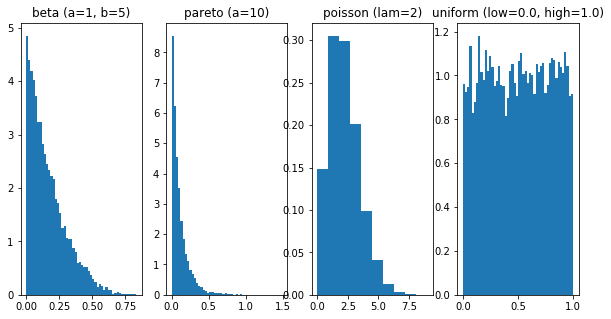

In [3]:
Distrib.num_dists = 1

# Define the distributions and parameters in a dictionary so it's easy to read!
distrib_dict = {
    'beta': {'a':1, 'b':5},
    'pareto': {'a':10},
    'poisson': {'lam':2},
    'uniform': {'low':0.0, 'high':1.0} # then add 'beta2' just to check
}

Distrib.generateDistribs(distrib_dict)   

# Plot the graph(s)!
plt.show()

## Multiple Samples

Now that we have some different distributions, let's sample from them a few times to see how they change.

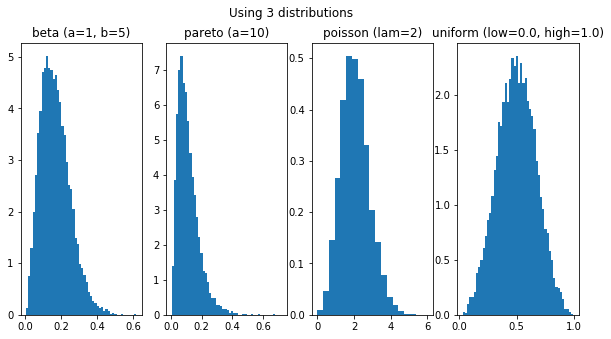

In [4]:
Distrib.num_dists = 3

Distrib.generateDistribs(distrib_dict)
plt.suptitle('Using %s distributions' % Distrib.num_dists)
plt.show()

Increasing the number of distributions, we can see the clear convergence to a Gaussian 

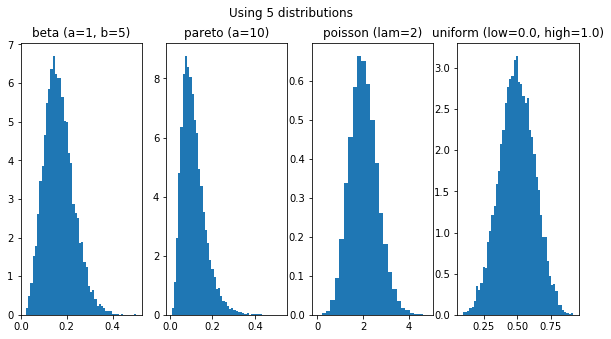

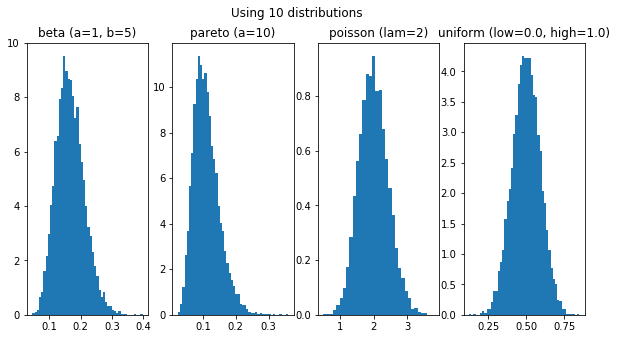

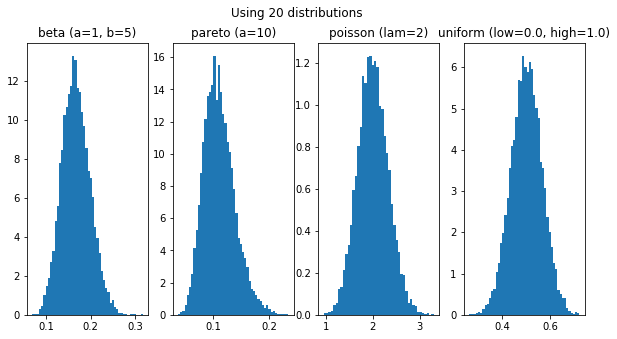

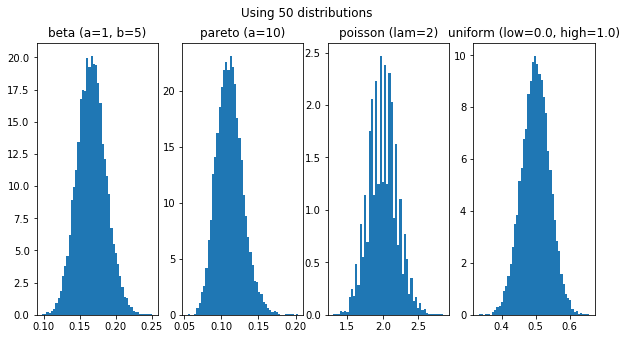

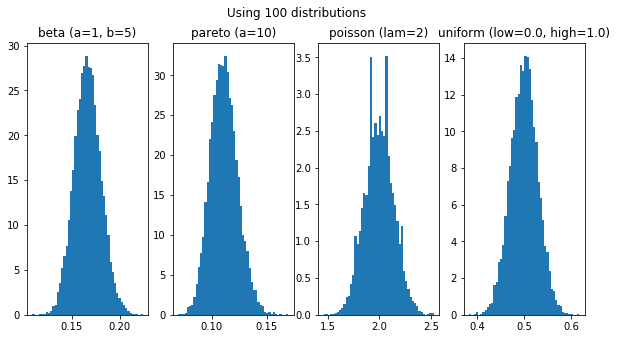

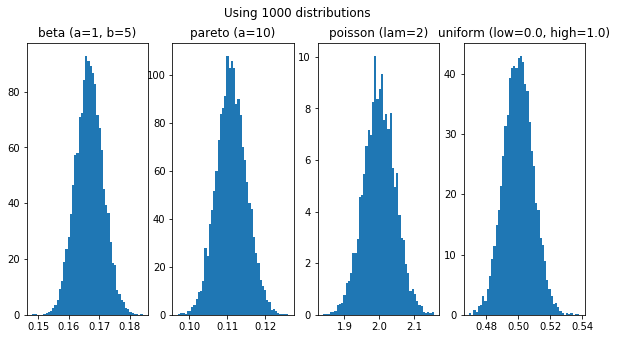

In [5]:
distrib_nums = [5,10,20,50,100,1000]

for i in distrib_nums:
    Distrib.num_dists = i
    
    Distrib.generateDistribs(distrib_dict)
    plt.suptitle('Using %s distributions' % i)
    plt.show()

*The issue with the plotting of the Poisson is a result of it being a discrete distribution, and the uneven binning of the possible discrete outputs from the distribution. To fix this, we can ensure an appropriate number of bins but it doesn't matter too much for the purposes of this notebook*

## Comparing to the corresponding Gaussian

Just to compare, let's see what the corresponding Gaussian looks like...

This is harder to do with flexibility as the moments are calculated different for each distribution. As we're using Python, there is of course a function for that. Scipy's stats module has some wonderful statistical functions that allow us to calculate the moments of a specified distribution, which we can then use to generate a normal distribution for comparison.

In [6]:
# Define the distributions and parameters for scipy (parameter names are different, unfortunately!)
# if we needed this as more of a class factory, then refactoring and consistent use of scipy would be needed

distrib_dict_scipy = {
    'beta': {'a':1, 'b':5},
    'lomax': {'c':10},
    'poisson': {'mu':2},
    'uniform': {'loc':0.0, 'scale':1.0}
}

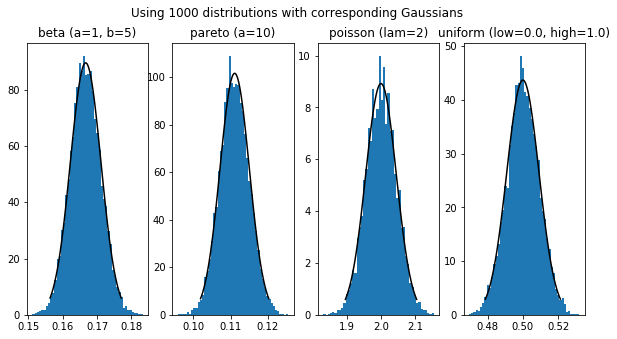

In [7]:
Distrib.num_dists = 1000
Distrib.generateDistribs(distrib_dict)

#print(plt.gcf(), type(plt.gcf()))

# Use the axes method to get each axis back and then add the Gaussian to each
# As the order of the plots and the dictionary is the same, it's fine!
axes_list = plt.gcf().axes

# Loop over the scipy params dictionary
for i, (name, params) in enumerate(distrib_dict_scipy.items()):
    
    # Same method as before, but this time for the scipy.stats module
    try:
        distrib_func = getattr(stats, name)
    except AttributeError:
        print("Cannot find "+sname+" in scipy's stats module!")
        raise
    
    # Use the wonderful stats method to calculate the first two moments
    try:
        mean, var = distrib_func.stats(**params, moments='mv')
    except TypeError:
        raise
    
    # Calculate the standard deviation
    sigma = np.sqrt(var)/np.sqrt(Distrib.num_dists)
    
    # Calculate what we need for the Gaussian
    dist = stats.norm(mean, sigma)
    x = np.linspace(stats.norm.ppf(0.01, loc=mean, scale=sigma), stats.norm.ppf(0.99, loc=mean, scale=sigma), 100)
    
    # Plot the Gaussian on the corresponding axis
    axes_list[i].plot(x, dist.pdf(x), '-k')
    
plt.suptitle('Using %s distributions with corresponding Gaussians' % Distrib.num_dists)
plt.show()

As we can see, at N=1000 distributions all different distributions have very closely approximated the Gaussian that you'd expect at the mean and variance of the original distribution.